## Overcome cold-start by personalizing our FaceRecognition before it goes live

This notebook should help you to get a quick overview about the structure and behaviour of our cold-start pipline. This pipline contains basicaly two python scripts called main.py and FaceEncoder.py. The main.py is our backbone script to which we are going to parse all the arguments which then decides where to get the pictures from, where to store it and which steps you would like to run. Contrary, FaceEncoder.py contains just all the necessary functions and classes which are executed from the main.py script. So practicaly you are working only with the main.py script while FaceEncoder is just providing the functionalities to the main.py script. 

First we will ignore the main.py script with which we will mainly configure the pipline and first get an intuition in the functionalities of FaceEncoder. So lets have a look what classes we find in the FaceEncoder script


### Extract and encode faces 

In [19]:
from FaceEncoder import *
import FaceEncoder
dir(FaceEncoder)

['FaceCluster',
 'FaceImageGenerator',
 'FaceRecognition',
 'GenerateFaces',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']

In [20]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tensorflow==2.8.0
mtcnn==0.1.1


You can see there are basically 4 classes ***GenerateFaces, FaceCluster, FaceImageGenerator*** and ***FaceRecognition*** which are also used in this sequential order.

***GenerateFaces*** is a class with multiple sub functions which are trying to detect faces in any given picture using the [Multi-task Cascaded Convolutional Networks (MTCNN)](https://pypi.org/project/mtcnn/). The process of MTCNN consists of three tasks (Face classification, Bounding box regression and Facial Landmark localization) of convolutional networks that are able to recognize faces and landmark location such as eyes, nose, and mouth. We then recenter the detected faces using the determined landmarks (eyes, node, mouth) because we need to make sure that width and height of the cropped faces are of equal size as input to our FaceRecognition model (required input 160x160 - output 1x128). Next we crop the faces out of the pictures and use the last layer of our face recognition model (here [FaceNet](https://arxiv.org/abs/1503.03832)) to encode the cropped faces and archive all the intermediate and final results in a .json database

Lets have a look what this class expects from us as input - but rember you communicate only via main.py script - so all the arguments need to be parsed to main.py

In [2]:
import inspect
inspect.signature(GenerateFaces)

<Signature (file_path, output='/mnt/golem/frodo/cropped_faces/', thr=0, plot=True, model_path='../dat/models/keras-facenet-h5/model.json', weight_path='../dat/models/keras-facenet-h5/model.h5', database='/mnt/golem/frodo/Database/FaceDB.json')>

We can see we need to specifiy a ... 
- file_path: the folder directory full of pictures from which you want to extract the faces
- output: an output directory/path where you would like to store the cropped faces 
- thr: a confidence threshold - probability of how sure the model is that this is realy a face
- model_path: this is the path to the FaceNet configuration file (FaceNet - is used to encode the images and later recognize the faces)
- weight_path: this is the path to the FaceNet weights
- database: this is the directory + filename where you want to store the database as well as how you would like to name it - most important keep the prefix .json


1) So the first thing I recommend to do is to create a folder in the directory of your choice create a folder in which you want to archive the cropped/extracted faces eg like me called "cropped_faces".
2) Next you look which pictures you want to extract and encode the faces from.
3) create in your directory of choise a folder in which you would like to archive your database .json file (I called this folder eg Database and named the database FaceDB.json)
4) you copy paste the configuration and weight files for the FaceNet model to any directory of choice

here I created a test directory with a folder called Database and a folder called cropped_faces

In [3]:
ls /mnt/golem/frodo/test/

ClusteredFaces/  cropped_faces/  Database/


both are empty

Now for illustration I am going to use a folder with a view pictures mainly jpg and some videos which will be ignored 

In [4]:
ls /mnt/golem/Photos/Sandro_externe_Festplatte/'Caren und Sandro Hochzeit'/

'@eaDir'/        IMG_0219.JPG*   IMG_0347.JPG*   IMG_0516.JPG*   IMG_0588.JPG*
 IMG_0129.JPG*   IMG_0220.JPG*   IMG_0355.JPG*   IMG_0517.JPG*   IMG_0589.JPG*
 IMG_0130.JPG*   IMG_0221.JPG*   IMG_0358.JPG*   IMG_0520.JPG*   IMG_0590.JPG*
 IMG_0131.JPG*   IMG_0222.JPG*   IMG_0362.JPG*   IMG_0522.JPG*   IMG_0591.JPG*
 IMG_0134.JPG*   IMG_0228.JPG*   IMG_0365.JPG*   IMG_0523.JPG*   IMG_0592.JPG*
 IMG_0135.JPG*   IMG_0231.JPG*   IMG_0372.JPG*   IMG_0525.JPG*   IMG_0593.JPG*
 IMG_0136.JPG*   IMG_0234.JPG*   IMG_0376.JPG*   IMG_0527.JPG*   IMG_0594.JPG*
 IMG_0137.JPG*   IMG_0236.JPG*   IMG_0378.JPG*   IMG_0529.JPG*   IMG_0595.JPG*
 IMG_0139.JPG*   IMG_0238.JPG*   IMG_0385.JPG*   IMG_0530.JPG*   IMG_0596.JPG*
 IMG_0140.JPG*   IMG_0241.JPG*   IMG_0388.JPG*   IMG_0531.JPG*   IMG_0597.JPG*
 IMG_0141.JPG*   IMG_0242.JPG*   IMG_0394.JPG*   IMG_0532.JPG*   IMG_0598.JPG*
 IMG_0143.JPG*   IMG_0243.JPG*   IMG_0398.JPG*   IMG_0534.JPG*   IMG_0599.JPG*
 IMG_0145.JPG*   IMG_0246.JPG*   IMG_0400.JPG*   IMG

Later when you interact with the main.py script you don t need to do this step but as we are using the functions directly to get some intuition we need to do one further step. Getting all the paths to the input images above.

***NOTE: For now the pipline just supports jpg|heic|PNG|JPG|HEIC***

In [5]:
import os
dir_path = "/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/"
file_path = [dir_path + img for img in os.listdir(dir_path) if img.split(".")[-1].upper() == "JPG"]   


I copied the two files for Facenet in this directory

In [21]:
ls ../dat/models/keras-facenet-h5/

model.h5  model.json


thats it for now ... lets have a look what happens if we interact with the class 

In [22]:
import warnings
warnings.filterwarnings('ignore')
DB = GenerateFaces(file_path=file_path, 
              output='/mnt/golem/frodo/test/cropped_faces/',
              thr=0.9,
              plot=False,
              model_path= '../dat/models/keras-facenet-h5/model.json', 
              weight_path='../dat/models/keras-facenet-h5/model.h5', 
              database='/mnt/golem/frodo/test/Database/FaceDB.json', # please fon t forget to include the non existing datbase with .json prefix
             )

In [23]:
DB

In [24]:
ls /mnt/golem/frodo/test/cropped_faces/

as you will notice nothing happend - also the folders you created are still empty. Thats because the Class just prepared and digested all your settings and is waiting till you let it run. To let it run you need to execute the **.run()** method which has two arguments *archive* and *batch_size* So lets kick it started

In [25]:
inspect.signature(DB.run)

<Signature (archive=True, batch_size=100)>

*archive* is just the argument to see if you would like to archive it into the json database or if you are just playing around without saving it. The *batch_size* argument give you the possibility to make intermediate saving of your proceessed faces. Lets say you run it on 10 k pictures you don t want to loose all the processed images just because the image 9'999 showed an error. So its wise to not keep the batch_size too high or too low. 

with the default of 100 it would save during the process of 270 pictures twice until it provides you the full database. first time after around 100 images and second time after around 200 images and the last time provides you the final save of all 270 processed images.

But now lets run it with the default settings

In [26]:
DB.run(archive=True, batch_size=100)

  0%|▏                                          | 1/286 [00:03<17:32,  3.69s/it]

[INFO] This face did not had high confidence 0.8201013207435608
[INFO] This face did not had high confidence 0.8076727390289307


  1%|▎                                          | 2/286 [00:05<11:57,  2.53s/it]

[INFO] This face did not had high confidence 0.8715643286705017
[INFO] This face did not had high confidence 0.7857363820075989
[INFO] This face did not had high confidence 0.7469950318336487
[INFO] This face did not had high confidence 0.7200292348861694


  1%|▍                                          | 3/286 [00:07<10:01,  2.13s/it]

[INFO] This face did not had high confidence 0.8324543833732605
[INFO] This face did not had high confidence 0.7792677283287048
[INFO] This face did not had high confidence 0.7702391147613525
[INFO] This face did not had high confidence 0.7547751069068909


  1%|▌                                          | 4/286 [00:08<09:01,  1.92s/it]

[INFO] This face did not had high confidence 0.8940570950508118
[INFO] This face did not had high confidence 0.8772303462028503
[INFO] This face did not had high confidence 0.8720620274543762
[INFO] This face did not had high confidence 0.8171386122703552
[INFO] This face did not had high confidence 0.8043897151947021
[INFO] This face did not had high confidence 0.7970994114875793
[INFO] This face did not had high confidence 0.7703896760940552


  2%|▊                                          | 5/286 [00:10<08:26,  1.80s/it]

[INFO] This face did not had high confidence 0.8471266627311707
[INFO] This face did not had high confidence 0.785067081451416
[INFO] This face did not had high confidence 0.754895031452179
[INFO] This face did not had high confidence 0.7251358032226562


  2%|▉                                          | 6/286 [00:13<09:56,  2.13s/it]

[INFO] This face did not had high confidence 0.8605392575263977
[INFO] This face did not had high confidence 0.7732752561569214
[INFO] This face did not had high confidence 0.7328199148178101


  2%|█                                          | 7/286 [00:14<09:33,  2.06s/it]

[INFO] This face did not had high confidence 0.7457028031349182


  3%|█▏                                         | 8/286 [00:16<08:49,  1.90s/it]

[INFO] This face did not had high confidence 0.8556941151618958


  3%|█▍                                        | 10/286 [00:21<10:18,  2.24s/it]

[INFO] This face did not had high confidence 0.8910768628120422
[INFO] This face did not had high confidence 0.8400996923446655


  4%|█▌                                        | 11/286 [00:23<09:35,  2.09s/it]

[INFO] This face did not had high confidence 0.820846676826477
[INFO] This face did not had high confidence 0.8163665533065796


  4%|█▊                                        | 12/286 [00:25<10:18,  2.26s/it]

[INFO] This face did not had high confidence 0.8695269227027893
[INFO] This face did not had high confidence 0.7860950231552124


  5%|█▉                                        | 13/286 [00:27<09:23,  2.06s/it]

[INFO] This face did not had high confidence 0.8546328544616699
[INFO] This face did not had high confidence 0.75575852394104
[INFO] This face did not had high confidence 0.7374276518821716


  5%|██                                        | 14/286 [00:31<11:20,  2.50s/it]

[INFO] This face did not had high confidence 0.8010016679763794
[INFO] This face did not had high confidence 0.7772378921508789
[INFO] This face did not had high confidence 0.7169545292854309


  5%|██▏                                       | 15/286 [00:32<09:54,  2.19s/it]

[INFO] This face did not had high confidence 0.8267537355422974


  6%|██▎                                       | 16/286 [00:34<08:55,  1.98s/it]

[INFO] This face did not had high confidence 0.7025002837181091


  7%|██▊                                       | 19/286 [00:38<07:16,  1.64s/it]

[INFO] This face did not had high confidence 0.7488691806793213


  7%|██▉                                       | 20/286 [00:39<06:59,  1.58s/it]

[INFO] This face did not had high confidence 0.8535307049751282


  7%|███                                       | 21/286 [00:41<06:36,  1.50s/it]

[INFO] This face did not had high confidence 0.8343779444694519


  8%|███▏                                      | 22/286 [00:43<07:17,  1.66s/it]

[INFO] This face did not had high confidence 0.8759685754776001
[INFO] This face did not had high confidence 0.7255628108978271


  8%|███▍                                      | 23/286 [00:45<07:39,  1.75s/it]

[INFO] This face did not had high confidence 0.8159449696540833


  9%|███▋                                      | 25/286 [00:49<08:25,  1.94s/it]

[INFO] This face did not had high confidence 0.8965761661529541
[INFO] This face did not had high confidence 0.7546069025993347
[INFO] This face did not had high confidence 0.7431280612945557
[INFO] This face did not had high confidence 0.7069715857505798
[INFO] This face did not had high confidence 0.7027873992919922


  9%|███▊                                      | 26/286 [00:50<07:43,  1.78s/it]

[INFO] This face did not had high confidence 0.7377351522445679


 10%|████                                      | 28/286 [00:53<07:05,  1.65s/it]

[INFO] This face did not had high confidence 0.7424609065055847


 11%|████▌                                     | 31/286 [00:57<06:22,  1.50s/it]

[INFO] This face did not had high confidence 0.896184504032135
[INFO] This face did not had high confidence 0.8123809099197388


 12%|████▊                                     | 33/286 [01:00<06:16,  1.49s/it]

[INFO] This face did not had high confidence 0.7955973148345947


 12%|████▉                                     | 34/286 [01:02<06:20,  1.51s/it]

[INFO] This face did not had high confidence 0.8318455815315247


 12%|█████▏                                    | 35/286 [01:03<06:06,  1.46s/it]

[INFO] This face did not had high confidence 0.8120992183685303


 13%|█████▌                                    | 38/286 [01:08<05:55,  1.43s/it]

[INFO] This face did not had high confidence 0.7418831586837769


 14%|██████                                    | 41/286 [01:12<05:54,  1.45s/it]

[INFO] This face did not had high confidence 0.896308422088623


 15%|██████▏                                   | 42/286 [01:13<05:49,  1.43s/it]

[INFO] This face did not had high confidence 0.8958647847175598


 15%|██████▍                                   | 44/286 [01:16<06:03,  1.50s/it]

[INFO] This face did not had high confidence 0.7307062745094299


 16%|██████▊                                   | 46/286 [01:20<06:22,  1.59s/it]

[INFO] This face did not had high confidence 0.8395479917526245


 17%|███████                                   | 48/286 [01:23<06:02,  1.52s/it]

[INFO] This face did not had high confidence 0.7715854644775391


 17%|███████▏                                  | 49/286 [01:24<05:47,  1.47s/it]

[INFO] This face did not had high confidence 0.7548209428787231


 17%|███████▎                                  | 50/286 [01:26<06:03,  1.54s/it]

[INFO] This face did not had high confidence 0.7045851945877075


 18%|███████▍                                  | 51/286 [01:28<06:20,  1.62s/it]

[INFO] This face did not had high confidence 0.7812275886535645


 18%|███████▋                                  | 52/286 [01:29<06:09,  1.58s/it]

[INFO] This face did not had high confidence 0.8715371489524841
[INFO] This face did not had high confidence 0.7222384214401245


 20%|████████▏                                 | 56/286 [01:35<05:50,  1.52s/it]

[INFO] This face did not had high confidence 0.8467769026756287


 20%|████████▎                                 | 57/286 [01:37<05:41,  1.49s/it]

[INFO] This face did not had high confidence 0.8099009990692139


 21%|████████▋                                 | 59/286 [01:40<05:42,  1.51s/it]

[INFO] This face did not had high confidence 0.7465050220489502


 21%|████████▉                                 | 61/286 [01:43<05:40,  1.51s/it]

[INFO] This face did not had high confidence 0.772377073764801


 22%|█████████▎                                | 63/286 [01:45<05:19,  1.43s/it]

[INFO] This face did not had high confidence 0.7605028748512268


 23%|█████████▌                                | 65/286 [01:48<05:02,  1.37s/it]

[INFO] This face did not had high confidence 0.8245902061462402


 23%|█████████▋                                | 66/286 [01:49<05:05,  1.39s/it]

[INFO] This face did not had high confidence 0.7824245095252991
[INFO] This face did not had high confidence 0.7719326019287109


 25%|██████████▌                               | 72/286 [01:58<05:04,  1.42s/it]

[INFO] This face did not had high confidence 0.7021337151527405


 27%|███████████▍                              | 78/286 [02:06<04:45,  1.37s/it]

[INFO] This face did not had high confidence 0.7585448026657104


 28%|███████████▌                              | 79/286 [02:08<04:58,  1.44s/it]

[INFO] This face did not had high confidence 0.7044929265975952


 28%|███████████▋                              | 80/286 [02:10<05:11,  1.51s/it]

[INFO] This face did not had high confidence 0.7043935060501099


 28%|███████████▉                              | 81/286 [02:11<05:06,  1.49s/it]

[INFO] This face did not had high confidence 0.881801187992096
[INFO] This face did not had high confidence 0.8202196955680847


 29%|████████████                              | 82/286 [02:12<05:02,  1.48s/it]

[INFO] This face did not had high confidence 0.8773731589317322
[INFO] This face did not had high confidence 0.8339458703994751


 29%|████████████▏                             | 83/286 [02:14<05:14,  1.55s/it]

[INFO] This face did not had high confidence 0.7132678627967834


 29%|████████████▎                             | 84/286 [02:16<05:11,  1.54s/it]

[INFO] This face did not had high confidence 0.8201238512992859


 30%|████████████▊                             | 87/286 [02:20<05:01,  1.52s/it]

[INFO] This face did not had high confidence 0.8191683292388916


 31%|████████████▉                             | 88/286 [02:22<05:05,  1.54s/it]

[INFO] This face did not had high confidence 0.7661916613578796
[INFO] This face did not had high confidence 0.7611925005912781
[INFO] This face did not had high confidence 0.7147238254547119


 32%|█████████████▎                            | 91/286 [02:27<05:16,  1.62s/it]

[INFO] This face did not had high confidence 0.7531765699386597
[INFO] This face did not had high confidence 0.7464669346809387
[INFO] This face did not had high confidence 0.7334588766098022


 32%|█████████████▌                            | 92/286 [02:28<05:00,  1.55s/it]

[INFO] This face did not had high confidence 0.7837204933166504


 33%|█████████████▋                            | 93/286 [02:29<04:42,  1.46s/it]

[INFO] This face did not had high confidence 0.8951795101165771
[INFO] This face did not had high confidence 0.7802697420120239


 34%|██████████████                            | 96/286 [02:34<04:34,  1.45s/it]

[INFO] This face did not had high confidence 0.7489154934883118


 34%|██████████████▏                           | 97/286 [02:35<05:00,  1.59s/it]

[INFO] This face did not had high confidence 0.8247107267379761
[INFO] This face did not had high confidence 0.7902894616127014


 34%|██████████████▍                           | 98/286 [02:38<06:04,  1.94s/it]

[INFO] This face did not had high confidence 0.7409864664077759
[INFO] This face did not had high confidence 0.7279375195503235
[INFO] This face did not had high confidence 0.7137230038642883


 35%|██████████████▎                          | 100/286 [02:41<05:27,  1.76s/it]

[INFO] This face did not had high confidence 0.8242120146751404


 35%|██████████████▍                          | 101/286 [02:44<05:57,  1.93s/it]

[INFO] This face did not had high confidence 0.798275351524353
[INFO] This face did not had high confidence 0.7372875213623047


 36%|██████████████▌                          | 102/286 [02:46<05:55,  1.93s/it]

[INFO] archive batch


 36%|██████████████▊                          | 103/286 [02:47<05:22,  1.76s/it]

[INFO] This face did not had high confidence 0.7313079237937927


 36%|██████████████▉                          | 104/286 [02:49<05:06,  1.68s/it]

[INFO] This face did not had high confidence 0.7050246000289917


 38%|███████████████▋                         | 109/286 [02:58<05:53,  1.99s/it]

[INFO] This face did not had high confidence 0.8637726306915283
[INFO] This face did not had high confidence 0.8625721335411072
[INFO] This face did not had high confidence 0.8350668549537659
[INFO] This face did not had high confidence 0.7649746537208557


 39%|███████████████▉                         | 111/286 [03:02<05:32,  1.90s/it]

[INFO] This face did not had high confidence 0.8812966346740723


 39%|████████████████                         | 112/286 [03:03<05:11,  1.79s/it]

[INFO] This face did not had high confidence 0.8603839874267578
[INFO] This face did not had high confidence 0.757150411605835


 42%|█████████████████▏                       | 120/286 [03:17<04:43,  1.71s/it]

[INFO] This face did not had high confidence 0.7571364641189575


 43%|█████████████████▍                       | 122/286 [03:21<04:56,  1.81s/it]

[INFO] This face did not had high confidence 0.8327735662460327


 43%|█████████████████▊                       | 124/286 [03:24<04:47,  1.78s/it]

[INFO] This face did not had high confidence 0.7188743948936462


 45%|██████████████████▍                      | 129/286 [03:33<04:53,  1.87s/it]

[INFO] This face did not had high confidence 0.8732711672782898


 45%|██████████████████▋                      | 130/286 [03:36<05:02,  1.94s/it]

[INFO] This face did not had high confidence 0.8095493912696838
[INFO] This face did not had high confidence 0.7248018980026245
[INFO] This face did not had high confidence 0.702415406703949


 47%|███████████████████                      | 133/286 [03:42<05:08,  2.02s/it]

[INFO] This face did not had high confidence 0.8880345821380615
[INFO] This face did not had high confidence 0.787703275680542
[INFO] This face did not had high confidence 0.7740920782089233
[INFO] This face did not had high confidence 0.7220562696456909


 47%|███████████████████▏                     | 134/286 [03:44<05:12,  2.06s/it]

[INFO] This face did not had high confidence 0.8264233469963074
[INFO] This face did not had high confidence 0.8191079497337341
[INFO] This face did not had high confidence 0.7171756625175476


 47%|███████████████████▎                     | 135/286 [03:46<05:07,  2.04s/it]

[INFO] This face did not had high confidence 0.7925707101821899
[INFO] This face did not had high confidence 0.7707319259643555


 48%|███████████████████▋                     | 137/286 [03:50<05:12,  2.10s/it]

[INFO] This face did not had high confidence 0.8546360731124878


 48%|███████████████████▊                     | 138/286 [03:52<05:18,  2.15s/it]

[INFO] This face did not had high confidence 0.8911105990409851
[INFO] This face did not had high confidence 0.8374534845352173
[INFO] This face did not had high confidence 0.8019408583641052
[INFO] This face did not had high confidence 0.7107413411140442


 49%|███████████████████▉                     | 139/286 [03:54<05:13,  2.13s/it]

[INFO] This face did not had high confidence 0.7796721458435059
[INFO] This face did not had high confidence 0.7544088363647461


 49%|████████████████████                     | 140/286 [03:57<05:09,  2.12s/it]

[INFO] This face did not had high confidence 0.8301681280136108
[INFO] This face did not had high confidence 0.7419277429580688


 49%|████████████████████▏                    | 141/286 [03:58<04:56,  2.05s/it]

[INFO] This face did not had high confidence 0.7300993204116821


 50%|████████████████████▎                    | 142/286 [04:00<04:49,  2.01s/it]

[INFO] This face did not had high confidence 0.7000803351402283


 50%|████████████████████▌                    | 143/286 [04:02<04:46,  2.01s/it]

[INFO] This face did not had high confidence 0.7437957525253296
[INFO] This face did not had high confidence 0.7415090799331665
[INFO] This face did not had high confidence 0.7240920662879944


 50%|████████████████████▋                    | 144/286 [04:04<04:44,  2.01s/it]

[INFO] This face did not had high confidence 0.703059196472168


 52%|█████████████████████▏                   | 148/286 [04:13<04:50,  2.10s/it]

[INFO] This face did not had high confidence 0.844982385635376
[INFO] This face did not had high confidence 0.7298596501350403


 52%|█████████████████████▎                   | 149/286 [04:15<04:46,  2.09s/it]

[INFO] This face did not had high confidence 0.8995878100395203
[INFO] This face did not had high confidence 0.8168240189552307


 54%|██████████████████████                   | 154/286 [04:25<04:24,  2.00s/it]

[INFO] This face did not had high confidence 0.7754601836204529


 54%|██████████████████████▏                  | 155/286 [04:27<04:28,  2.05s/it]

[INFO] This face did not had high confidence 0.8826764225959778
[INFO] This face did not had high confidence 0.7674059271812439
[INFO] This face did not had high confidence 0.7488707304000854


 55%|██████████████████████▎                  | 156/286 [04:29<04:35,  2.12s/it]

[INFO] This face did not had high confidence 0.7948398590087891
[INFO] This face did not had high confidence 0.7431668043136597


 55%|██████████████████████▌                  | 157/286 [04:31<04:40,  2.17s/it]

[INFO] This face did not had high confidence 0.8053065538406372


 55%|██████████████████████▋                  | 158/286 [04:34<04:38,  2.17s/it]

[INFO] This face did not had high confidence 0.7060202360153198


 56%|██████████████████████▉                  | 160/286 [04:38<04:33,  2.17s/it]

[INFO] This face did not had high confidence 0.8055816292762756
[INFO] This face did not had high confidence 0.7857215404510498
[INFO] This face did not had high confidence 0.7493205666542053
[INFO] This face did not had high confidence 0.7056534290313721


 56%|███████████████████████                  | 161/286 [04:40<04:22,  2.10s/it]

[INFO] This face did not had high confidence 0.8520123958587646
[INFO] This face did not had high confidence 0.8398824334144592
[INFO] This face did not had high confidence 0.8023640513420105


 57%|███████████████████████▎                 | 163/286 [04:43<03:42,  1.81s/it]

[INFO] This face did not had high confidence 0.8434528708457947


 57%|███████████████████████▌                 | 164/286 [04:45<03:45,  1.85s/it]

[INFO] This face did not had high confidence 0.755613386631012


 58%|███████████████████████▉                 | 167/286 [04:50<03:32,  1.79s/it]

[INFO] This face did not had high confidence 0.8418983817100525
[INFO] This face did not had high confidence 0.8270146250724792


 59%|████████████████████████                 | 168/286 [04:52<03:26,  1.75s/it]

[INFO] This face did not had high confidence 0.7432834506034851


 59%|████████████████████████▎                | 170/286 [04:57<04:04,  2.11s/it]

[INFO] This face did not had high confidence 0.8952199220657349


 60%|████████████████████████▊                | 173/286 [05:04<04:07,  2.19s/it]

[INFO] This face did not had high confidence 0.8346210718154907


 61%|████████████████████████▉                | 174/286 [05:06<04:02,  2.17s/it]

[INFO] This face did not had high confidence 0.7865143418312073
[INFO] This face did not had high confidence 0.7819886207580566


 61%|█████████████████████████                | 175/286 [05:08<03:56,  2.13s/it]

[INFO] This face did not had high confidence 0.8316071629524231


 62%|█████████████████████████▎               | 177/286 [05:12<03:54,  2.15s/it]

[INFO] This face did not had high confidence 0.8791711330413818
[INFO] This face did not had high confidence 0.7810574173927307
[INFO] This face did not had high confidence 0.70998215675354


 63%|█████████████████████████▊               | 180/286 [05:18<03:41,  2.09s/it]

[INFO] This face did not had high confidence 0.7443931698799133
[INFO] This face did not had high confidence 0.7136808633804321


 64%|██████████████████████████▏              | 183/286 [05:24<03:31,  2.05s/it]

[INFO] This face did not had high confidence 0.7936002016067505


 65%|██████████████████████████▌              | 185/286 [05:27<02:56,  1.75s/it]

[INFO] This face did not had high confidence 0.8454460501670837


 65%|██████████████████████████▋              | 186/286 [05:29<02:54,  1.75s/it]

[INFO] This face did not had high confidence 0.8956068158149719
[INFO] This face did not had high confidence 0.8775217533111572


 65%|██████████████████████████▊              | 187/286 [05:31<02:56,  1.78s/it]

[INFO] This face did not had high confidence 0.7548368573188782


 66%|██████████████████████████▉              | 188/286 [05:32<02:43,  1.67s/it]

[INFO] This face did not had high confidence 0.8219798803329468


 66%|███████████████████████████              | 189/286 [05:34<02:37,  1.63s/it]

[INFO] This face did not had high confidence 0.8950625061988831


 66%|███████████████████████████▏             | 190/286 [05:35<02:26,  1.53s/it]

[INFO] This face did not had high confidence 0.8530440330505371


 67%|███████████████████████████▍             | 191/286 [05:37<02:22,  1.50s/it]

[INFO] This face did not had high confidence 0.8911411762237549
[INFO] This face did not had high confidence 0.8858382105827332


 68%|███████████████████████████▊             | 194/286 [05:42<02:36,  1.70s/it]

[INFO] This face did not had high confidence 0.8291205167770386


 68%|███████████████████████████▉             | 195/286 [05:44<02:37,  1.74s/it]

[INFO] This face did not had high confidence 0.7048508524894714


 69%|████████████████████████████             | 196/286 [05:46<02:38,  1.76s/it]

[INFO] This face did not had high confidence 0.7463976740837097
[INFO] This face did not had high confidence 0.7385158538818359


 69%|████████████████████████████▏            | 197/286 [05:47<02:27,  1.66s/it]

[INFO] This face did not had high confidence 0.7427911162376404


 69%|████████████████████████████▍            | 198/286 [05:49<02:23,  1.63s/it]

[INFO] This face did not had high confidence 0.8084883093833923
[INFO] This face did not had high confidence 0.8050629496574402
[INFO] This face did not had high confidence 0.7235776782035828


 70%|████████████████████████████▌            | 199/286 [05:50<02:18,  1.60s/it]

[INFO] This face did not had high confidence 0.8895428776741028
[INFO] This face did not had high confidence 0.8486712574958801
[INFO] This face did not had high confidence 0.8165459036827087
[INFO] This face did not had high confidence 0.7829198241233826


 70%|████████████████████████████▋            | 200/286 [05:52<02:13,  1.55s/it]

[INFO] This face did not had high confidence 0.8379907011985779


 71%|████████████████████████████▉            | 202/286 [05:55<02:16,  1.62s/it]

[INFO] This face did not had high confidence 0.8797547817230225
[INFO] This face did not had high confidence 0.7637028098106384
[INFO] This face did not had high confidence 0.7416806817054749
[INFO] This face did not had high confidence 0.7367175817489624


 71%|█████████████████████████████▏           | 204/286 [05:58<02:14,  1.65s/it]

[INFO] This face did not had high confidence 0.7276772260665894
[INFO] archive batch


 72%|█████████████████████████████▍           | 205/286 [06:00<02:13,  1.65s/it]

[INFO] This face did not had high confidence 0.8111263513565063


 72%|█████████████████████████████▌           | 206/286 [06:02<02:15,  1.69s/it]

[INFO] This face did not had high confidence 0.8315452933311462
[INFO] This face did not had high confidence 0.792361319065094


 72%|█████████████████████████████▋           | 207/286 [06:03<02:08,  1.62s/it]

[INFO] This face did not had high confidence 0.7215944528579712


 73%|██████████████████████████████           | 210/286 [06:07<01:50,  1.46s/it]

[INFO] This face did not had high confidence 0.7738093137741089


 74%|██████████████████████████████▏          | 211/286 [06:09<01:46,  1.43s/it]

[INFO] This face did not had high confidence 0.8713675141334534


 74%|██████████████████████████████▍          | 212/286 [06:10<01:45,  1.43s/it]

[INFO] This face did not had high confidence 0.8561896681785583


 74%|██████████████████████████████▌          | 213/286 [06:11<01:45,  1.45s/it]

[INFO] This face did not had high confidence 0.7412838935852051


 75%|██████████████████████████████▋          | 214/286 [06:13<01:44,  1.45s/it]

[INFO] This face did not had high confidence 0.7477356195449829


 75%|██████████████████████████████▊          | 215/286 [06:15<01:47,  1.52s/it]

[INFO] This face did not had high confidence 0.7585089206695557
[INFO] This face did not had high confidence 0.7033815979957581


 76%|██████████████████████████████▉          | 216/286 [06:16<01:49,  1.56s/it]

[INFO] This face did not had high confidence 0.7945816516876221


 76%|███████████████████████████████▎         | 218/286 [06:19<01:44,  1.54s/it]

[INFO] This face did not had high confidence 0.8383544087409973


 77%|███████████████████████████████▋         | 221/286 [06:25<01:57,  1.81s/it]

[INFO] This face did not had high confidence 0.8887138366699219


 78%|████████████████████████████████         | 224/286 [06:29<01:32,  1.50s/it]

[INFO] This face did not had high confidence 0.7259232997894287


 79%|████████████████████████████████▎        | 225/286 [06:31<01:36,  1.58s/it]

[INFO] This face did not had high confidence 0.7049223184585571


 80%|████████████████████████████████▋        | 228/286 [06:36<01:37,  1.67s/it]

[INFO] This face did not had high confidence 0.821485161781311


 80%|████████████████████████████████▊        | 229/286 [06:38<01:44,  1.83s/it]

[INFO] This face did not had high confidence 0.7980023622512817


 80%|████████████████████████████████▉        | 230/286 [06:40<01:47,  1.93s/it]

[INFO] This face did not had high confidence 0.8713970184326172
[INFO] This face did not had high confidence 0.8586416840553284
[INFO] This face did not had high confidence 0.8372920751571655
[INFO] This face did not had high confidence 0.7660742402076721
[INFO] This face did not had high confidence 0.7075297832489014


 81%|█████████████████████████████████▎       | 232/286 [06:44<01:37,  1.80s/it]

[INFO] This face did not had high confidence 0.8526430130004883
[INFO] This face did not had high confidence 0.7688080072402954


 82%|█████████████████████████████████▋       | 235/286 [06:47<01:14,  1.47s/it]

[INFO] This face did not had high confidence 0.7520689964294434


 83%|█████████████████████████████████▊       | 236/286 [06:49<01:11,  1.42s/it]

[INFO] This face did not had high confidence 0.8519705533981323


 83%|█████████████████████████████████▉       | 237/286 [06:50<01:08,  1.39s/it]

[INFO] This face did not had high confidence 0.8923743367195129


 83%|██████████████████████████████████       | 238/286 [06:52<01:07,  1.40s/it]

[INFO] This face did not had high confidence 0.7258520722389221


 84%|██████████████████████████████████▎      | 239/286 [06:53<01:05,  1.39s/it]

[INFO] This face did not had high confidence 0.8564967513084412


 84%|██████████████████████████████████▍      | 240/286 [06:54<01:04,  1.41s/it]

[INFO] This face did not had high confidence 0.7835062146186829
[INFO] This face did not had high confidence 0.7050947546958923


 84%|██████████████████████████████████▌      | 241/286 [06:56<01:08,  1.52s/it]

[INFO] This face did not had high confidence 0.762640118598938


 86%|███████████████████████████████████      | 245/286 [07:02<01:00,  1.48s/it]

[INFO] This face did not had high confidence 0.8915069699287415


 86%|███████████████████████████████████▎     | 246/286 [07:03<00:59,  1.49s/it]

[INFO] This face did not had high confidence 0.7186365127563477


 87%|███████████████████████████████████▊     | 250/286 [07:09<00:51,  1.44s/it]

[INFO] This face did not had high confidence 0.7715098261833191


 88%|███████████████████████████████████▉     | 251/286 [07:11<00:50,  1.46s/it]

[INFO] This face did not had high confidence 0.8799186944961548
[INFO] This face did not had high confidence 0.7868287563323975


 88%|████████████████████████████████████▎    | 253/286 [07:14<00:51,  1.56s/it]

[INFO] This face did not had high confidence 0.8060901761054993
[INFO] This face did not had high confidence 0.7545638084411621


 89%|████████████████████████████████████▍    | 254/286 [07:15<00:48,  1.53s/it]

[INFO] This face did not had high confidence 0.7809202671051025


 89%|████████████████████████████████████▌    | 255/286 [07:17<00:47,  1.53s/it]

[INFO] This face did not had high confidence 0.8274662494659424


 90%|████████████████████████████████████▋    | 256/286 [07:18<00:46,  1.53s/it]

[INFO] This face did not had high confidence 0.8857988119125366
[INFO] This face did not had high confidence 0.8567924499511719
[INFO] This face did not had high confidence 0.8152034878730774
[INFO] This face did not had high confidence 0.7861062288284302


 91%|█████████████████████████████████████▏   | 259/286 [07:23<00:42,  1.57s/it]

[INFO] This face did not had high confidence 0.7505717277526855


 91%|█████████████████████████████████████▎   | 260/286 [07:25<00:41,  1.59s/it]

[INFO] This face did not had high confidence 0.8200051188468933


 91%|█████████████████████████████████████▍   | 261/286 [07:27<00:40,  1.62s/it]

[INFO] This face did not had high confidence 0.8895983099937439
[INFO] This face did not had high confidence 0.8361006379127502


 92%|█████████████████████████████████████▌   | 262/286 [07:28<00:39,  1.63s/it]

[INFO] This face did not had high confidence 0.8390974402427673
[INFO] This face did not had high confidence 0.8168632388114929
[INFO] This face did not had high confidence 0.750956654548645
[INFO] This face did not had high confidence 0.7162851095199585


 92%|█████████████████████████████████████▋   | 263/286 [07:30<00:37,  1.63s/it]

[INFO] This face did not had high confidence 0.7942036986351013


 92%|█████████████████████████████████████▊   | 264/286 [07:31<00:35,  1.61s/it]

[INFO] This face did not had high confidence 0.8515651226043701


 93%|█████████████████████████████████████▉   | 265/286 [07:33<00:36,  1.75s/it]

[INFO] This face did not had high confidence 0.8111875653266907
[INFO] This face did not had high confidence 0.7220502495765686


 93%|██████████████████████████████████████▏  | 266/286 [07:36<00:37,  1.88s/it]

[INFO] This face did not had high confidence 0.8718352913856506
[INFO] This face did not had high confidence 0.8667272329330444
[INFO] This face did not had high confidence 0.7672078609466553


 93%|██████████████████████████████████████▎  | 267/286 [07:38<00:36,  1.90s/it]

[INFO] This face did not had high confidence 0.7782056331634521
[INFO] This face did not had high confidence 0.7661208510398865


 94%|██████████████████████████████████████▍  | 268/286 [07:39<00:32,  1.81s/it]

[INFO] This face did not had high confidence 0.890637218952179


 95%|██████████████████████████████████████▊  | 271/286 [07:44<00:24,  1.65s/it]

[INFO] This face did not had high confidence 0.8625719547271729
[INFO] This face did not had high confidence 0.7305055856704712


 95%|███████████████████████████████████████▏ | 273/286 [07:47<00:21,  1.65s/it]

[INFO] This face did not had high confidence 0.8082014918327332
[INFO] This face did not had high confidence 0.761362612247467


 96%|███████████████████████████████████████▎ | 274/286 [07:49<00:20,  1.74s/it]

[INFO] This face did not had high confidence 0.8122090697288513
[INFO] This face did not had high confidence 0.8076387643814087


 96%|███████████████████████████████████████▍ | 275/286 [07:51<00:18,  1.67s/it]

[INFO] This face did not had high confidence 0.7572136521339417
[INFO] This face did not had high confidence 0.7406524419784546
[INFO] This face did not had high confidence 0.7382014989852905


 97%|███████████████████████████████████████▋ | 277/286 [07:54<00:14,  1.56s/it]

[INFO] This face did not had high confidence 0.7679912447929382


 98%|███████████████████████████████████████▉ | 279/286 [07:57<00:10,  1.57s/it]

[INFO] This face did not had high confidence 0.8647590279579163


 99%|████████████████████████████████████████▌| 283/286 [08:02<00:04,  1.46s/it]

[INFO] This face did not had high confidence 0.8335424065589905
[INFO] This face did not had high confidence 0.7885861992835999


 99%|████████████████████████████████████████▋| 284/286 [08:04<00:02,  1.45s/it]

[INFO] This face did not had high confidence 0.7497850060462952


100%|████████████████████████████████████████▊| 285/286 [08:05<00:01,  1.48s/it]

[INFO] This face did not had high confidence 0.8103532195091248


100%|█████████████████████████████████████████| 286/286 [08:07<00:00,  1.70s/it]

[INFO] This face did not had high confidence 0.7256993651390076
[INFO] preparing final archive of FaceDB ... 
looped through 286 pictures, detected 958 faces in 187 pictures
[INFO] archived 'FaceDB' sucessfully!!!
[INFO] There are currently 958 faces in FaceDB encoded


as you can see it is telling you whenever there were some faces detected that where below the specified confidential threshold  in ***GenerateFaces*** - here set to 0.9.

You can also see that it tells you when it saved an intermediate result of the processed faces into the specified .json file

At the end it is also telling you also how many pictures it looked at and how many faces where detected from how many pictures - some do not contain any subject on it or the confidence was too low to consider.

You probably noticed by now that the whole module works only on CPU and is therefore not as efficient. for me it took ~1.75sec/image so there might be potential to improve the efficiency (56k faces took me ~1.5days)

So what happened on a high level when you executed the **run** method?

.run() launch the pipline by looping through each specified image detect **if** and **where** there is a face (using MTCNN), recenter (the detected face using landmarks in the face (mouth, nose, eyes) to not deform the face when you resize it for FaceNet since the width and height needs to be equal for Facenet 160x160), crop, encode (FaceNet) and archive the intermediate as well as final results

You are going to see 2 outputs: 

1) archives the intermediate and final results in a json (our reference database used for clustering) file with the following structure:

* uniqueID: 
     * path_pic_orig : str - path of original image
     * path_croped_pic : str - path of cropped image/face
     * encodings: list - last layer of FaceNet (1x128)
     * recentered_rectangle: list - coordinates of cropped recentered face in original image in form of [x1, x2, y1, y2]
     * detector : dic - MTCNN output containing Face Classification, Bounding Box Regression and Facial Landmark Localization  
         + box : list - coordinates of original non-recentered detected face in original image in form of [x1, y1, width, height]
         + confidence : float - probability that the given rectangle is a real face 
         + keypoints : dic - landmark coordinates 
            - left_eye :  tuple of x,y ccoordinates marking the left eye
            - right_eye : tuple of x,y ccoordinates marking the right eye
            - nose : tuple of x,y ccoordinates marking the nose eye
            - mouth_left : tuple of x,y ccoordinates marking the left mouth
            - mouth_right : tuple of x,y ccoordinates marking the right mouth

2) each detected face will be cropped out of the original image and saved in the specified output directory in the following
structure

* if the probability is higher than the specified threshold (default = 0)        
    + uniqueID_cropped_face.png: file in specified ouput directory        
* otherwise
    + less_confident_faces: folder
        + {}(confidence)_cropped_face.png: file in sub of output directory     


with the method *get_database()* we get the database back stored at the directory specified in arument database of class ***GenerateFaces***

In [14]:
DB.get_database()

{1: {'path_pic_orig': '/mnt/golem/Photos/Sandro_externe_Festplatte/Sandro_Kinderbilder/IMG_20210419_125004.jpg',
  'path_croped_pic': '/mnt/golem/frodo/test/cropped_faces/1_cropped_face.png',
  'encodings': [[-0.07142594456672668,
    -0.07283046096563339,
    0.05879543349146843,
    -0.15045763552188873,
    -0.0016598980873823166,
    -0.018279608339071274,
    -0.03335172310471535,
    0.04661116003990173,
    -0.029063569381833076,
    -0.06361272931098938,
    -0.02444196306169033,
    0.03492160886526108,
    0.09983844310045242,
    0.07466188818216324,
    0.10730278491973877,
    0.10074461996555328,
    0.17230835556983948,
    -0.2536625862121582,
    -0.07945604622364044,
    -0.09535766392946243,
    0.016504010185599327,
    -0.12766249477863312,
    -0.062276601791381836,
    -0.045237522572278976,
    0.05739504098892212,
    0.04138249158859253,
    0.055459506809711456,
    0.15227553248405457,
    -0.0465380996465683,
    0.0046759676188230515,
    -0.10367482900619

Now we should see the cropped faces in the specified output directory
As you can see the cropped face start with an uniqueID the name cropped_face in the format of png. In case you have specified a confidence threshold above - it will create automaticaly a folder called *less_confiident_faces/* which contain all the faces which had lower face confidence 

In [27]:
ls /mnt/golem/frodo/test/cropped_faces/

100_cropped_face.png*  38_cropped_face.png*   678_cropped_face.png*
101_cropped_face.png*  390_cropped_face.png*  679_cropped_face.png*
102_cropped_face.png*  391_cropped_face.png*  67_cropped_face.png*
103_cropped_face.png*  392_cropped_face.png*  680_cropped_face.png*
104_cropped_face.png*  393_cropped_face.png*  681_cropped_face.png*
105_cropped_face.png*  394_cropped_face.png*  682_cropped_face.png*
106_cropped_face.png*  395_cropped_face.png*  683_cropped_face.png*
107_cropped_face.png*  396_cropped_face.png*  684_cropped_face.png*
108_cropped_face.png*  397_cropped_face.png*  685_cropped_face.png*
109_cropped_face.png*  398_cropped_face.png*  686_cropped_face.png*
10_cropped_face.png*   399_cropped_face.png*  687_cropped_face.png*
110_cropped_face.png*  39_cropped_face.png*   688_cropped_face.png*
111_cropped_face.png*  3_cropped_face.png*    689_cropped_face.png*
112_cropped_face.png*  400_cropped_face.png*  68_cropped_face.png*
113_cropped_face.png*  401_cropped_face.png*  690_

We can also see a json file in the specified database directory 

In [28]:
ls /mnt/golem/frodo/test/Database/

FaceDB.json*


### Cluster cropped faces

Now since we have extracted and encoded all the faces out of the provided pictures. We can start to cluster the faces to facilitate the profiling of our friends, relative or neighbor. For the clustering we are going to use the Class ***FaceCluster*** which has only one method called *Cluster()* 

In [29]:
inspect.signature(FaceCluster)

<Signature (file_path='/mnt/golem/frodo/Database/FaceDB.json', IDs=None)>

as you can see the class has two arguments *file_path* and *IDs*

* file_path: the database directory you have specified above
* IDs: here you would have the option to cluster only a part of the extracted and logged faces.One scenario to use this would be for example that you run GenrateFaces above with a confidential threshold of 0 and filter afterwards for the clustering the confidential threshold you want. NOTE: when applying a thr the faces below that threshold will not be encoded and logged in the database - this way you would still have it in the database and can filter afterwards and monitor which threshold suits your dataset best - we could also implement something like a blur detector - shouldbe very simple on which we could chose which faces to cluster - if none we will take all faces

In [30]:
clust = FaceCluster(file_path="/mnt/golem/frodo/test/Database/FaceDB.json", IDs=None)
clust

.Cluster() runs [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html) on the face encodings of FaceNet last layer. HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise. Performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection. In practice this means that HDBSCAN returns a good clustering straight away with little or no parameter tuning -- and the primary parameter, minimum cluster size, is intuitive and easy to select. HDBSCAN is ideal for exploratory data analysis; it's a fast and robust algorithm that you can trust to return meaningful clusters (if there are any).

The default allows only clusters with >= 10 faces/cluster

It will return cluster labels of HDBSCAN that need to be parsed to the class ***FaceImageGenerator*** More about that later

In [31]:
labelIDs = clust.Cluster()

[INFO] Clustering
[INFO] # unique faces: 5



with this test folder of images I could identify potentially 5 subjects. This information will be parsed as already mentioned to ***FaceImageGenerator*** (Actually we could merge the two classes in a next version).

***FaceImageGenerator*** is a class that archives the clustered faces into same cluster folders to get a structured profile for each subject that was detected in the provided images. This facilitates the evaluation of correct and wrong clusters.
So its kind of visualizing the cluster results generated with the **Cluster()** method. 



In [35]:
print(inspect.signature(FaceImageGenerator))
inspect.signature(FaceImageGenerator.GenerateImages)

()


<Signature (self, labels, cluster_dir='/mnt/golem/frodo/', OutputFolderName='ClusteredFaces', MontageOutputFolder='Montage', file_path='/mnt/golem/frodo/Database/FaceDB.json', IDs=None)>

as you can see there is no argument for the class to intiate. However, there are a few arguments for the method **GenerateImages** 

* labels: the labels returned by ***FaceCluster.Cluster***
* cluster_dir: the directory path where you would like to output the cluster results it will create a folder named after the next argument
* OutputFolderName: the folder name in which the cluster results will be archived and created
* MontageOutputFolder: the folder name in which we will save a collection of faces as an overview
* file_path: the datbase directory of above
* IDs: the same IDs which where specified above

In [38]:
ClustResult = FaceImageGenerator()
ClustResult

Before we run this - lets remind us what folders we have in our directory and lets check after we have run the ***GenerateImages*** method

In [40]:
ls /mnt/golem/frodo/test

cropped_faces/  Database/


In [42]:
ClustResult.GenerateImages(labels=labelIDs, 
                           cluster_dir="/mnt/golem/frodo/test/",
                           OutputFolderName = "ClusteredFaces", 
                           MontageOutputFolder = "Montage",
                           file_path= "/mnt/golem/frodo/test/Database/FaceDB.json",
                           IDs = None)

0it [00:00, ?it/s]

[INFO] There are 431 faces for FaceCluster ID: -1


3it [00:03,  1.18it/s]

[INFO] There are 10 faces for FaceCluster ID: 0
[INFO] There are 22 faces for FaceCluster ID: 1
[INFO] There are 74 faces for FaceCluster ID: 2


4it [00:03,  1.37it/s]

[INFO] There are 344 faces for FaceCluster ID: 3


5it [00:05,  1.07it/s]

[INFO] There are 77 faces for FaceCluster ID: 4


6it [00:05,  1.08it/s]


Now lets check what this has created

In [43]:
ls /mnt/golem/frodo/test/

ClusteredFaces/  cropped_faces/  Database/


as promised there is now a folder named after you have specified in *OutputFolderName*. Lets have a look what does this folder contain now

In [44]:
ls /mnt/golem/frodo/test/ClusteredFaces/

Face_0/  Face_-1/  Face_1/  Face_2/  Face_3/  Face_4/  Montage/


As you can see each identified cluster (due to HDBSCAN) created its own folder with faces clustered together. You will also have been noticed the folder Montage (if you kept the default). This contains a plot of maximal25 faces out of these face cluster folderstoget a quick overview about what faces where contained.

Now you need to go manually through these folders and evaluate which subjects these are. I would recommend to duplicate thes clusteres and just remove (move) the wrong images out of the folders such that you have homogen subject folders - rename the folders based on the subject names and come back to this notebook

### Restructure your database with the subject labels

I hope the clustering worked for you - at least my experience was the more faces you could extract from the same person the better it performs. Maybe the default of >=10 faces per cluster might be to harsh for a smal dataset - but this really depends how many faces of the same subject you have provided. As I mentioned I run this with 56k faces and received 110 subject profiles from which I was impressed how accurate it was. I had to move only a few faces and one full folder. 


Now as you have manually adjusted the folders we can go back to our first class ***GenerateFaces***. This class provides you another method called *restructure_DB*. Lets see what the input is

In [45]:
inspect.signature(GenerateFaces.restructure_DB)

<Signature (self, cluster_path='/mnt/golem/frodo/ClusteredFaces_clean/', new_DB_path='/mnt/golem/frodo/Database/New_FaceDB.json', ignore=['Face_-1'], ig_faces=True)>

* cluster_path: the directory path to the cleaned subject profiles
* new_DB_path: the path + new filename of the new restructured database which will be used later for face recognition
* ignore: a list of foldernames you would like to ignore and not add to the reference database
* ig_faces: is a bool and will ignore all folder that are called Faces_* indicating that you did not relabel this folder yet

Lets restructure our manually adjusted subjects

In [47]:
ls /mnt/golem/frodo/test/ClusteredFaces/

Caren/  Face_-1/  Hubert/  Josephine/  Montage/  Sandro/  Tanja/


In [50]:
new_DB = GenerateFaces(None, database='/mnt/golem/frodo/test/Database/FaceDB.json').restructure_DB(cluster_path="/mnt/golem/frodo/test/ClusteredFaces/",
                            new_DB_path="/mnt/golem/frodo/test/Database/New_FaceDB.json",
                            ignore=["Montage"], 
                            ig_faces=True)


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8958.36it/s]


as you can see the new database has now not the uniqueID but the folder/subject name as key the values have the same structure as the original database just that we have now multiple faces for each entry. Very similar to the docs indexing where you take the words of a document as index for the documents (learned in recommender systems and data mining II)

In [53]:
new_DB.keys()

dict_keys(['Hubert', 'Josephine', 'Sandro', 'Tanja', 'Caren'])

In [54]:
new_DB["Sandro"]

{'path_pic_orig': ['/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0129.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0136.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0137.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0140.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0141.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0148.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0163.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0215.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0228.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0231.JPG',
  '/mnt/golem/Photos/Sandro_externe_Festplatte/Caren und Sandro Hochzeit/IMG_0252.JPG',
  '/mnt/golem/P

### Face Recognition

now we are ready to recognize (in my small scenario) just 5 subjects and relate the encoding of a given face (live feed camera) to our reference database using the class ***FaceRecognition***

arguments are:

* image_path : str
    + path to an image (or snap of live camera)

* database : dic 
    +  the new restructured database containing face encodings along with the name of the person on the image as key

* model_path: str
    + path to FaceNet configuration file 
* weight_path: str
    + path to FaceNet weights

In [61]:
FaceRecognition().who_is_it(image_path='/mnt/golem/frodo/ClusteredFaces_clean/Sandro_Bruno/face_44976.png',
               database= new_DB)

it's Sandro, the distance is 0.7056843910182866


(0.7056843910182866, 'Sandro')

So it seems the pictures is me lets have a look if its really me

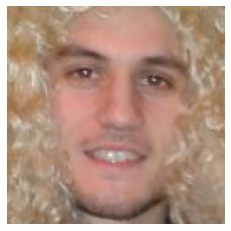

In [69]:
import matplotlib.pyplot as plt
img = plt.imread('/mnt/golem/frodo/ClusteredFaces_clean/Sandro_Bruno/face_44976.png')
plt.axis('off')
plt.imshow(img)

ta da...its really me in my nice carneval costume as women - do you like my blond hair :-P 

In [70]:
FaceRecognition().who_is_it(image_path='/mnt/golem/frodo/ClusteredFaces_clean/Jürgen_Schäck/face_52726.png',
               database= new_DB)

Not in the database.


(1.1760291260651194, 'Tanja')

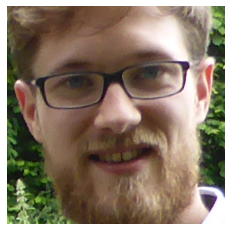

In [71]:
img = plt.imread('/mnt/golem/frodo/ClusteredFaces_clean/Jürgen_Schäck/face_52726.png')
plt.axis('off')
plt.imshow(img)

Awesome, it works my best friend Jürgen was not in my illustrated datbase as you can see on the keys of the database

In [73]:
list(new_DB.keys())

['Hubert', 'Josephine', 'Sandro', 'Tanja', 'Caren']

## Pipline

Obviously, we are not going to work in a Jupyter Noetbook to run the pipline - since we want to automate it and trigger it without going in the code. Thats why I have created the main.py script to which you are going to parse all the inputs illustrated above

First, lets have a look what arguments you can parse to the main.py script

In [13]:
!python main.py -h

usage: main.py [-h] -c CONF [-e [RUN]] [-cl [CLUSTER]] [-r [RESTRUCTUREDB]]

arguments to control the pipline

optional arguments:
  -h, --help            show this help message and exit
  -c CONF, --conf CONF  path to the JSON configuration file
  -e [RUN], --run [RUN]
                        do you want to encode
  -cl [CLUSTER], --cluster [CLUSTER]
                        do you want to cluster
  -r [RESTRUCTUREDB], --restructureDB [RESTRUCTUREDB]
                        do you want to restructure


you can see there is one required configuration file you need to parse in 

the other three are optional and state which stages you want to run -e for encoding -cl for clustering and r for restructuring your database

Here you can have a look at the configuration file just adjust it to your paths. then you should be set

In [11]:
cat conf.json

{
    "subfolders": null,
     "cluster": false, 
     "prefix": "jpg|heic|PNG|JPG|HEIC", 
     "archive": true, 
     "input_dir": "/mnt/golem/Photos/Sandro_externe_Festplatte/Sandro_Kinderbilder/", 
     "output_dir": "/mnt/golem/frodo/test/cropped_faces/", 
     "thr": 0, 
     "plot": false, 
     "model_path": "../dat/models/keras-facenet-h5/model.json", 
     "weight_path": "../dat/models/keras-facenet-h5/model.h5", 
     "run": false, 
     "batch_size": 100, 
     "IDs": null, 
     "DB_path": "/mnt/golem/frodo/test/Database/FaceDB.json", 
     "cluster_dir": "/mnt/golem/frodo/test/", 
     "cluster_folder_name": "ClusteredFaces", 
     "montage_folder_name": "Montage", 
     "restructureDB": false, 
     "cluster_path": "/mnt/golem/frodo/test/ClusteredFaces_clean/", 
     "new_DB_path": "/mnt/golem/frodo/test/Database/New_FaceDB.json", 
     "ignore": ["Face_-1", "Montage"], 
     "ig_faces": true
}

In [ ]:
!python main.py -c conf.json -e True -cl True

In [ ]:
!python main.py -c conf.json -r True